In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc

2026-02-28 21:55:20.015175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-28 21:55:20.015597: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-28 21:55:20.074442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-28 21:55:21.477438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
# Step 3: Load Dataset from Google Drive
train = 'src/dataset/KDDTrain+.txt'
test = 'src/dataset/KDDTest+.txt'

In [3]:
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

In [4]:
train_df.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [5]:
test_df.head()

,0,tcp,private,REJ,0.1,0.2,0.3,0.4,0.5,0.6,...,0.04.1,0.06.1,0.00.3,0.00.4,0.00.5,0.00.6,1.00.2,1.00.3,neptune,21
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21


In [6]:
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]

In [7]:
train_df.columns = column_names
test_df.columns = column_names

In [8]:
print("Train shape:", train_df.shape, "\nTest shape:", test_df.shape)

Train shape: (125972, 43) 
Test shape: (22543, 43)


In [9]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [10]:
train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  str    
 2   service                      125972 non-null  str    
 3   flag                         125972 non-null  str    
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13  root_shell

In [11]:
train_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,...,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,...,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [12]:
# Step 4: Binary Classification (Normal vs Attack)
train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Step 5: One-Hot Encoding for Categorical Features
categorical_cols = ['protocol_type', 'service', 'flag']
full_df = pd.concat([train_df, test_df])
full_df = pd.get_dummies(full_df, columns=categorical_cols)

train_encoded = full_df.iloc[:len(train_df)].copy()
test_encoded = full_df.iloc[len(train_df):].copy()

In [13]:
train_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,146,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
2,0,232,8153,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,199,420,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,False


In [14]:
# Step 6: Scale and separate features/labels
X_train = train_encoded.drop(['label', 'difficulty'], axis=1).apply(pd.to_numeric, errors='coerce')
y_train = train_encoded['label']

X_test = test_encoded.drop(['label', 'difficulty'], axis=1).apply(pd.to_numeric, errors='coerce')
y_test = test_encoded['label']

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Random Forest Report:
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.63      0.77     12832

    accuracy                           0.78     22543
   macro avg       0.82      0.80      0.78     22543
weighted avg       0.84      0.78      0.78     22543



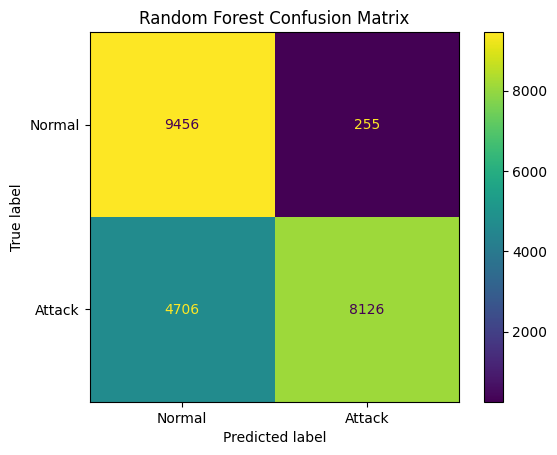

In [15]:
# Step 7: Random Forest Model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 0]

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf, labels=[0,1]), display_labels=["Normal", "Attack"]).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

E0000 00:00:1772295932.898825   37161 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1772295932.908736   37161 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9822 - loss: 0.0549 - val_accuracy: 0.9915 - val_loss: 0.0235
Epoch 2/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9908 - loss: 0.0262 - val_accuracy: 0.9939 - val_loss: 0.0189
Epoch 3/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9924 - loss: 0.0224 - val_accuracy: 0.9931 - val_loss: 0.0185
Epoch 4/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9926 - loss: 0.0209 - val_accuracy: 0.9924 - val_loss: 0.0226
Epoch 5/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9930 - loss: 0.0195 - val_accuracy: 0.9936 - val_loss: 0.0175
Epoch 6/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9935 - loss: 0.0185 - val_accuracy: 0.9944 - val_loss: 0.0170
Epoch 7/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9933 - loss: 0.0179 - val_accuracy: 0.9948 - val_loss: 0.0159
Epoch 8/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9935 - loss: 0

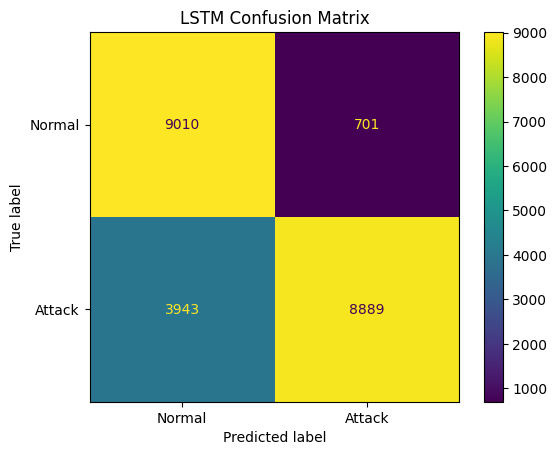

In [16]:
# Step 8: LSTM Model (requires 3D input)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
y_prob_lstm = lstm_model.predict(X_test_lstm).flatten()

print(classification_report(y_test, y_pred_lstm))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lstm, labels=[0,1]), display_labels=["Normal", "Attack"]).plot()
plt.title("LSTM Confusion Matrix")
plt.show()

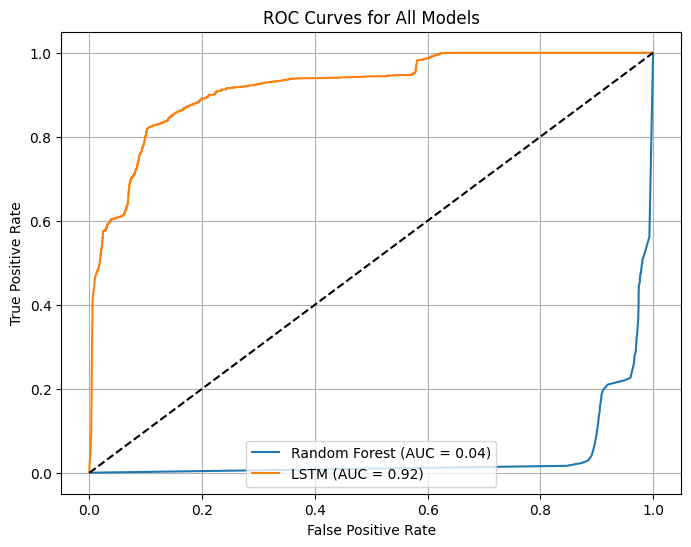

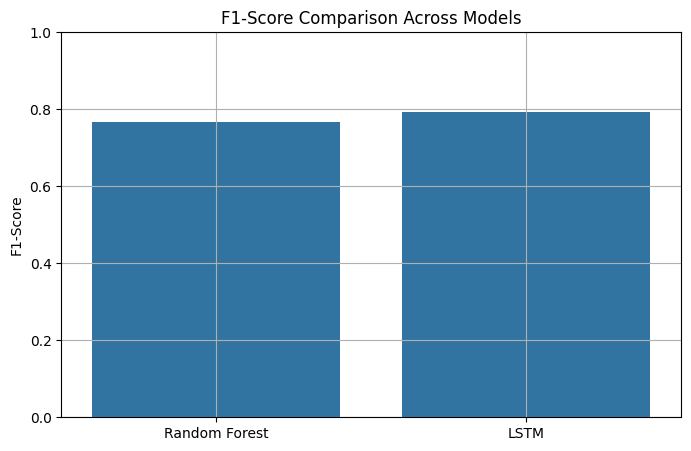

In [17]:
# Step 10c: ROC Curves
# Get probabilities

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc(fpr_lstm, tpr_lstm):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: F1-score Comparison
f1_rf = f1_score(y_test, y_pred_rf)
f1_lstm = f1_score(y_test, y_pred_lstm)

plt.figure(figsize=(8, 5))
sns.barplot(x=['Random Forest', 'LSTM'], y=[f1_rf, f1_lstm])
plt.title('F1-Score Comparison Across Models')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()